In [18]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [19]:
SIZE = 2048
theta = np.linspace(-np.pi/2, np.pi/2, SIZE)
bl = 1000. # baseline, cm east-west
fq = 100e6 # spectral frequency, Hz
c = 3e10 # speed of light, cm / s

## Visualizing the Fringe Pattern

Recall that we derived the equation for a visibility:
\begin{equation}
V(\vec b, \nu) = \int{A(\hat s)\cdot I(\hat s)\cdot e^{-2\pi i \vec b \cdot \hat s / \lambda} d\Omega}
\end{equation}

Below, we are going to take a look at the ``fringe" term of this integral---the $e^{-2\pi i \vec b \cdot \hat s / \lambda}$ part that represents the direction-dependent phase response of a baseline.

We will do this in 1D, so that $\vec b\cdot \hat s$ reduces to $b\sin\theta$ for $\theta$ being an angle from zenith.

In [20]:
# This is an interactive plot where you can change
# the length of a baseline and see the change in the
# fringe pattern for a fixed frequency.

%matplotlib inline
from ipywidgets import interact

def plt_fringe(bl):
    plt.figure(figsize=(5,5))
    plt.clf()
    ax2 = plt.subplot(111,projection='polar')
    fringe_pattern = np.exp(-2j * np.pi * bl * np.sin(theta) / c * fq)
    plt.polar(theta, 0.1 * fringe_pattern.real + 1)
    ax2.set_theta_offset(np.pi/2)
    ax2.set_yticks([])
    ax2.set_thetamin(-90)
    ax2.set_thetamax(90)
    plt.title('Fringe versus Angle')
    plt.show()
    
i = interact(plt_fringe, bl=(500, 1500))

interactive(children=(IntSlider(value=1000, description='bl', max=1500, min=500), Output()), _dom_classes=('wi…

Of course, with a dish, we can only see part of the sky at a time (not the whole fringe pattern).

In [21]:
bl = 4000. # cm

def plt_beam(point):
    plt.figure(figsize=(5,5))
    plt.clf()
    ax2 = plt.subplot(111,projection='polar')
    beam_pattern = np.exp(-(theta+point)**2 / (2 * 0.1**2)) # Gaussian beam pattern
    fringe_pattern = np.exp(-2j * np.pi * bl * np.sin(theta) / c * fq)
    plt.polar(theta, 0.1 * fringe_pattern.real + 1)
    plt.polar(theta, 0.1 * beam_pattern * fringe_pattern.real + 1)
    plt.polar(theta, beam_pattern)
    ax2.set_theta_offset(np.pi/2)
    ax2.set_yticks([])
    ax2.set_thetamin(-90)
    ax2.set_thetamax(90)
    plt.title('Response versus Angle')
    plt.show()
    
i = interact(plt_beam, point=(-np.pi/2,np.pi/2))

interactive(children=(FloatSlider(value=0.0, description='point', max=1.5707963267948966, min=-1.5707963267948…

## Synthesis Imaging

In this section, we explore the Fourier relationship between
the visibility measured by the interferometer and the
distribution of intensity on the sky.

We derived in class that, for the small-angle approximation
where $\ell\equiv\sin\theta_x\approx\theta_x$ and 
$m\equiv\sin\theta_y\approx\theta_y$, we had the relationship:
\begin{equation}
V(u,v)= e^{-2\pi i w} \int\!\!\int{A(\theta_x,\theta_y) \cdot
I(\theta_x,\theta_y) \cdot
e^{-2\pi i (u\theta_x + v\theta_y)} d\theta_x\ d\theta_y}
\end{equation}

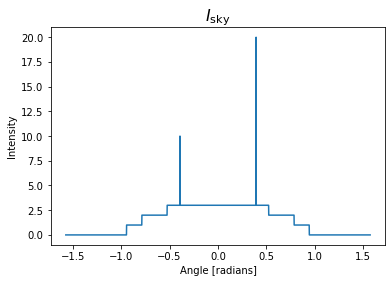

In [22]:
# Now let's make something to put up on the sky: a picture

I_sky = np.zeros(SIZE)
I_sky[SIZE//5:4*SIZE//5] = 1
I_sky[SIZE//4:3*SIZE//4] = 2
I_sky[SIZE//3:2*SIZE//3] = 3
I_sky[3*SIZE//8] = 10
I_sky[5*SIZE//8] = 20

plt.figure()
plt.title('$I_{\\rm sky}$', fontsize=16)
plt.plot(theta, I_sky)
plt.ylabel('Intensity')
_ = plt.xlabel('Angle [radians]')

Great. And this intensity is laid out on the (curved) sky where it is integrated over by the fringe pattern of our interferometer:

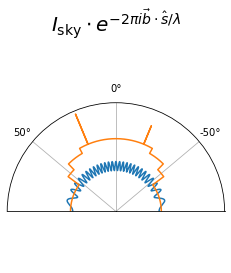

In [23]:
# Overlay the fringe pattern and the intensity on the sky

ax = plt.subplot(111,projection='polar')
fringe_pattern = np.exp(-2j * np.pi * bl * np.sin(theta) / c * fq)
plt.polar(theta, 0.1 * fringe_pattern.real + 1)
plt.polar(theta, 1 + np.log10(I_sky.real + 1))
ax.set_theta_offset(np.pi/2)
ax.set_yticks([])
ax.set_thetamin(-90)
ax.set_thetamax(90)
_ = plt.title(r'$I_{\rm sky}\cdot e^{-2\pi i \vec b \cdot \hat s / \lambda}$', fontsize=20)

Now, instead of one interferometer observing the sky and integrating
one fringe pattern, we will use a bunch: here, 2500 baselines of different
lengths. If you are efficient (look at ``Goloumb Rulers" on Wikipedia), you might be able to do this with $\sim$70 dishes.

In [24]:
# Integrate a fringe pattern against the sky for many baselines
bls = np.linspace(0, 50000, 2500)
V = {} # visibilities
for bl in bls:
    fringe_pattern = np.exp(-2j * np.pi * bl * np.sin(theta) / c * fq)
    V[bl] = np.sum(I_sky * fringe_pattern)

Now, to prove how awesome interferometers are, we will put all the different $V(u,v=0)$ visibilities we created onto what is called the ``$uv$ plane", where $u$ and $v$ describe the inverse angles that are the Fourier complement to $\theta_x$ and $\theta_y$.  Below, we grid our interferometer's measurements into an array so that each bin of the array is characterized by a $u$ coordinate and contains the visibility measured at that $u$.

In [25]:
# 
UMAX = 250
URES = 0.5
USIZE = int(UMAX / URES)
u_coord = np.linspace(-UMAX, UMAX, USIZE, endpoint=False)
u_coord = np.fft.fftshift(u_coord)
u_plane = np.zeros(USIZE, dtype=complex)
u_sampl = np.zeros(USIZE, dtype=complex)
for bl,vis in V.items():
    u_bin = int(np.around(bl * fq / c / URES))
    u_plane[u_bin] += vis
    u_sampl[u_bin] += 1
    u_plane[-u_bin] += vis.conj()
    u_sampl[-u_bin] += 1
u_plane /= np.where(u_sampl > 0, u_sampl, 1)

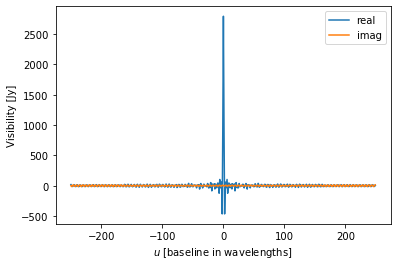

In [26]:
plt.figure()
plt.plot(np.fft.fftshift(u_coord), np.fft.fftshift(u_plane.real), label='real')
plt.plot(np.fft.fftshift(u_coord), np.fft.fftshift(u_plane.imag), label='imag')
plt.ylabel('Visibility [Jy]')
plt.xlabel('$u$ [baseline in wavelengths]')
_ = plt.legend(loc='best')

Ok, now for the big test. We've suggested that the array above, representing the $uv$ plane, should be the Fourier transform of the sky. Is it?

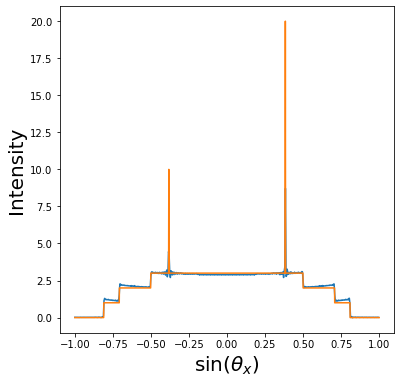

In [27]:
%matplotlib inline
I_sky_reconstruct = np.fft.ifft(u_plane)
x = np.fft.fftfreq(USIZE, URES)
plt.figure(figsize=(6,6))
plt.plot(np.fft.fftshift(x), np.exp(-1)*np.fft.fftshift(I_sky_reconstruct))
plt.plot(np.sin(theta), I_sky)
plt.ylabel('Intensity', fontsize=20)
plt.xlabel(r'$\sin(\theta_x)$', fontsize=20)
plt.show()

What we got was definitely related to $I_{\rm sky}$, although there are some discrepencies. For one, there seems to be an amplitude difference that is direction dependent. This comes from the Jacobian (size of differential chunks) because interferometers ``see" the sky in $\sin\theta$, while flux is natively distributed in $\theta$.


We also see ther are some weird artifacts: some $\sin x/x$ ringing around point sources, some bumps around the edges of our step functions.  Where do you think these come from?